# k-Nearest Neighbor (KNN) practice
Basic Image Classification and cross-validation.

In [1]:
import matplotlib.pyplot as plt
from data_utils import load_CIFAR10
import random
import numpy as np
# It makes matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules.
%load_ext autoreload
%autoreload 2

In [2]:
# Load the data from each batch.
data_dir = "./datasets/cifar-10-batches-py"
X_train, Y_train, X_test, Y_test = load_CIFAR10(data_dir)

# Check the size of training data and test data.
print "Training data shape: ", X_train.shape
print "Training labels shape: ", Y_train.shape
print "Test date shape: ", X_test.shape
print "Test labels shape: ", Y_test.shape

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test date shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Visualize some examples from the dataset.

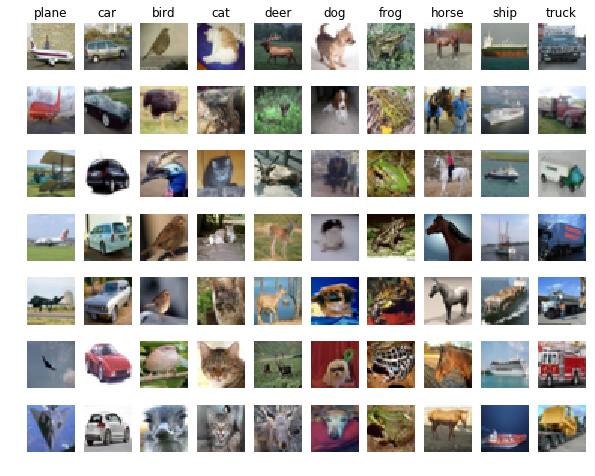

In [3]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(Y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## Training the model.
**The training process of k-NN is to simply remember the data.**
 

In [4]:
# Initialize a group of subsample.
num_training = 1000
mask = range(num_training)
X_train = X_train[mask]
Y_train = Y_train[mask]

num_test = 100
mask = range(num_test)
X_test = X_test[mask]
Y_test = Y_test[mask]

In [5]:
# Reshape the image data into rows
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
Y_train = X_train.reshape(X_train.shape[0], -1)
Y_test = X_test.reshape(X_test.shape[0], -1)

# Check the size of lists after reshape.
print "X_train: ", X_train.shape
print "X_test: ", X_test.shape

X_train:  (1000, 3072)
X_test:  (100, 3072)


# Predict the labels of test data.

In [6]:
# Define a group of function to compute the distances between test data and training data.
# Here L2 distance is used.
# By comparing the distances to predict the labels of test data.
def two_loop_distance(X_train, X_test):    
    num_train = X_train.shape[0]
    num_test = X_test.shape[0]
    
    dists = np.zeros((num_test, num_train))

#     print "X_test[2] shape: ", X_test[2].shape
#     print "X_train[2] shape: ", X_train[2].shape
        
    for i in xrange(num_test):
        for j in xrange(num_train):
            dists[i, j] = np.sqrt(np.sum((X_test[i] - X_train[j]) ** 2))
    return dists

def one_loop_distance(X_train, X_test):
    num_train = X_train.shape[0]
    num_test = X_test.shape[0]
    
    dists = np.zeros((num_test, num_train))
    
#     print "X_test[2] shape: ", X_test[2].shape
#     print "X_train shape: ", X_train.shape
        
    for i in xrange(num_test):
        dists[i, :] = np.sqrt(np.sum((X_test[i] - X_train) ** 2, axis = 1))
    return dists
    
def no_loop_distance(X_train, X_test):    
    num_train = X_train.shape[0]
    num_test = X_test.shape[0]
    
#     print "X_test shape: ", X_test.shape
#     print "X_train shape: ", X_train.shape
    
    dists = np.zeros((num_test, num_train))
    
    X_test_square_sum = np.sum(X_test ** 2, axis = 1, keepdims = True)
    X_train_square_sum = np.sum(X_train ** 2, axis = 1)
    dists = np.sqrt(X_test_square_sum + X_train_square_sum - 2 * np.dot(X_test, X_train.T))
    
#     print "====================================="
#     print "X_test_square_sum shape: ", X_test_square_sum.shape
#     print "X_train_square_sum shape: ", X_train_square_sum.shape
#     print "dists shape: ", dists.shape
   
    return dists

In [7]:
# Use k-NN to predict the labels of test data.
def predict(dists, Y_train, Y_test, k=1):
    # Ensure the shape is matched.
#     print "Y_test shape: ", Y_test.shape
#     print "Y_train shape: ", Y_train.shape  
#     print "dists shape: ", dists.shape  
  
    assert(dists.shape == (Y_test.shape[0], Y_train.shape[0]))
    
    num_test = Y_test.shape[0]
    Y_pred = np.zeros(num_test)
    
    # np.argsort return an array of the indexes of smallest value in the source list.
    for i in xrange(num_test):
        Y_closest = []
        Y_train = np.argsort(dists[i, :])
        Y_closest = Y_train[: k]
    
        # np.argmax return the value appears for the most time in the source array
        cnt = np.bincount(Y_closest)
        Y_pred[i] = np.argmax(cnt)
        
    return Y_pred  

In [10]:
# Compute the two loop dists between training images and test images.
dists = two_loop_distance(X_train, X_test)

# Compute the accuracy of correct examples with k = 1.
Y_pred = predict(dists, Y_train, Y_test, k = 1)
num_correct = np.sum(Y_pred == Y_test)
accuracy = float(num_correct) / num_test
print "Correct: %d / %d ; The accuracy is %f" % (num_correct, num_test, accuracy)

Correct: 0 / 100 ; The accuracy is 0.000000


/home/vmoonodd/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  


## Cross validation
In this part, we determine the hyperparameter k with cross-validation.

In [9]:
num_folds = 5
# k_choice = [1, 3, 5, 8, 10, 15, 20, 50, 100]
k_choice = [3, 5]

X_train_folds = []
Y_train_folds = []

# Split the data into folds.
X_train_folds = np.split(X_train, num_folds)
Y_train_folds = np.split(Y_train, num_folds)
    
# A dictionary stored the result with the format of "k": "accuracy".
k_accuracy = {}

for k in k_choice:
    k_accuracy[k] = []
    for i in xrange(num_folds):
        X_train_val = np.concatenate(X_train_folds[0: i] + X_train_folds[i+1: ])
        Y_train_val = np.concatenate(Y_train_folds[0: i] + Y_train_folds[i+1: ])
        X_valid = X_train_folds[i]
        Y_valid = Y_train_folds[i]
 
        # Predict the labels of validation folds.
        dists = two_loop_distance(X_train_val, X_valid)
        Y_pred_val = predict(dists, Y_train_val, Y_valid, k=k)
        num_pred_val = np.sum(Y_pred_val == Y_valid)
        accuracy = float(num_pred_val) / Y_pred_val.shape[0]
        k_accuracy[k] = k_accuracy.get(k,[]) + [accuracy]
         

# Print out the computed accuracies.
for k in sorted(k_accuracy):
    for accuracy in k_accuracy[k]:
        print "k = %d, accuracy = %f" % (k, accuracy)
    

/home/vmoonodd/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


k = 3, accuracy = 0.000000
k = 3, accuracy = 0.000000
k = 3, accuracy = 0.000000
k = 3, accuracy = 0.000000
k = 3, accuracy = 0.000000
k = 5, accuracy = 0.000000
k = 5, accuracy = 0.000000
k = 5, accuracy = 0.000000
k = 5, accuracy = 0.000000
k = 5, accuracy = 0.000000


In [ ]:
# Plot the raw observation.
for k in k_choices:
    accuracies = k_accuracy[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_accuracy.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_accuracy.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()